# SymPyとは
代数演算のライブラリです。  
Symbolicな演算（文字を数値としてではなくそのまま計算する演算）を可能にします。  

In [1]:
import sympy as sy
sy.init_printing()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## シンボルの定義

In [3]:
# シンボルを定義
a = sy.Symbol("a")
a

In [4]:
# 複数のシンボルを同時に定義
x, y = sy.symbols("x y")

In [5]:
# LaTexの記法を使える（raw文字列にしないとエスケープ文字と認識する）
theta, gamma = sy.symbols(r"\theta \gamma")
theta, gamma

In [6]:
# 正の実数として定義
r = sy.Symbol("r", positive=True)

# 実数として定義
q = sy.Symbol("q", real=True)

文字の情報を与えないと非常に一般的な複素数として計算することがあるので、なるべく情報を与えるようにしましょう。

## 基本演算

In [7]:
a**2 + x - theta

In [8]:
a**2 / a

In [9]:
(x + y)**3

### 式の展開など

In [10]:
f = (x + y)**3
f.expand()

In [11]:
# x^2の係数
f.expand().coeff(x, n=2)

## 微分や極限

In [12]:
f = sy.sin(x)/x
f.limit(x, 0)

In [13]:
# xで偏微分
f = 3 * x**2 * y + x * y**2
f.diff(x)

In [14]:
# 代入（シンボルも代入できる）
f.subs([(y, a**2)])

## NumPyのufuncに変換
シンボリックな表現をNumPyのufuncに変換できます。  
これは結構すごいと思います。  
シンボリックな計算をしたあと、数値計算を簡単にすることができます。

In [15]:
x, a, b, c = sy.symbols("x a b c")
f = a * x**2 + b * x + c
f

In [16]:
# ４引数を持つ関数を定義
args = (x, a, b, c)
func = sy.lambdify(args, f, "numpy")

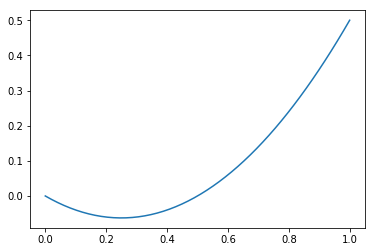

In [17]:
# 実際に数値を代入(ufuncとして振る舞い、ベクトル演算が可能)
xx = np.linspace(0, 1)
plt.plot(xx, func(xx, 1, -0.5, 0))
plt.show()

# 応用例
SymPyとNumPyの組み合わせが強力であることを示す例として、二重振り子を数値計算で解くということを試みます。  
もちろん普通に解いてもしょうがないので、座標設定からラグランジアン、そして運動方程式をシンボリックに求め、最後に数値計算することにします。

### モデル設定
原点からy軸負方向に１つ目の質点が長さ$r_1$のひもでぶら下がっていて、その先に２つ目の質点が長さ$r_2$のひもでぶら下がっているとします。  
それぞれの質点のy軸とのなす角をそれぞれ$\theta_1, \theta_2$とします。

In [18]:
# 変数と関数を定義
t = sy.Symbol("t", real=True)
r1, r2, m1, m2, g = sy.symbols(r"r_1 r_2 m_1 m_2 g", positive=True)
# theta1, theta2 = sy.symbols(r"\theta_1 \theta_2", real=True)
theta1 = sy.Function(r"\theta_1")(t)
theta2 = sy.Function(r"\theta_2")(t)
theta1_dot, theta2_dot = sy.symbols(r"\dot{\theta_1} \dot{\theta_2}")

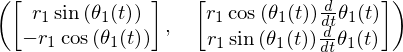

In [19]:
# 質点１の位置と速度
x1 = sy.Matrix([r1 * sy.sin(theta1), - r1 * sy.cos(theta1)])
v1 = x1.diff(t)
x1, v1

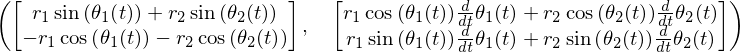

In [20]:
# 質点２の位置と速度
x2 = x1 + sy.Matrix([r2 * sy.sin(theta2), - r2 * sy.cos(theta2)])
v2 = x2.diff(t)
x2, v2

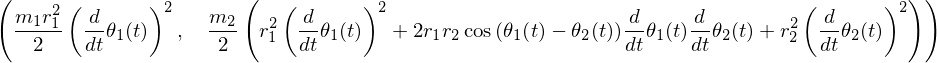

In [21]:
# 運動エネルギー
T1 = (m1 * (v1[0]**2 + v1[1]**2) / 2).simplify()
T2 = (m2 * (v2[0]**2 + v2[1]**2) / 2).simplify()
T1, T2

In [22]:
# ポテンシャル
V1 = m1 * g * x1[1]
V2 = m2 * g * x2[1]
V1, V2

運動エネルギーとポテンシャルが求まったので、ラグランジアン $L(\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2})$ を得ることができます。

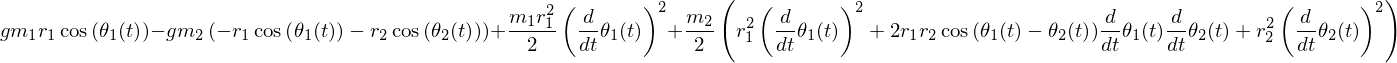

In [23]:
L = T1 + T2 - V1 - V2
L

だんだん結果は複雑になってきましたが、人間側は相当楽をしています。  
ラグランジアンから運動方程式はそれぞれ、
$$\frac{d}{dt} \frac{\partial L}{\partial \dot{\theta_1}}=\frac{\partial L}{\partial \theta_1}$$
$$\frac{d}{dt} \frac{\partial L}{\partial \dot{\theta_2}}=\frac{\partial L}{\partial \theta_2}$$
となるので、

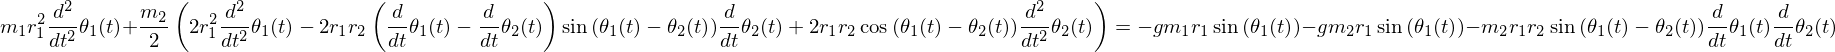

In [24]:
# 質点１の運動方程式
EOM_1 = sy.Eq(L.diff(theta1.diff(t)).diff(t), L.diff(theta1)) 
EOM_1

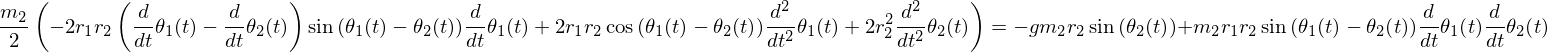

In [25]:
# 質点２の運動方程式
EOM_2 = sy.Eq(L.diff(theta2.diff(t)).diff(t), L.diff(theta2)) 
EOM_2

$\ddot{\theta_1}, \ddot{\theta_2}$について解くと、

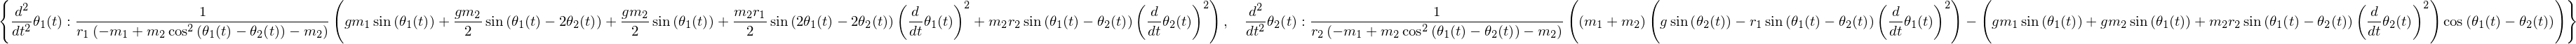

In [26]:
EOMs = sy.solve([EOM_1, EOM_2], (theta1.diff(t, 2), theta2.diff(t, 2)))
EOMs

In [27]:
# 関数を変数に置き換える
t1, t2 = sy.symbols(r"\theta_1 \theta_2")
diff2dot = [(theta1.diff(t), theta1_dot),
            (theta2.diff(t), theta2_dot)]
theta1_ddot = EOMs[theta1.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])
theta2_ddot = EOMs[theta2.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])

In [28]:
# NumPyの関数に変換する
args = (t1, t2, theta1_dot, theta2_dot, m1, m2, r1, r2, g)
func1 = sy.lambdify(args, theta1_ddot, "numpy")
func2 = sy.lambdify(args, theta2_ddot, "numpy")

In [29]:
# 数値計算
from scipy.integrate import ode

def time_evolve(t, y, params):
    theta1, theta2, theta1_dot, theta2_dot = y
    return [theta1_dot, theta2_dot,
            func1(*y, *params),
            func2(*y, *params)]

y0 = [np.pi * 1.01, np.pi * 1.01, 0, 0]
params = {"m1": 1, "m2": 1, "r1": 0.1, "r2": 0.1, "g": 9.8}
solver = ode(time_evolve).set_initial_value(y0, 0).set_f_params(params.values())

dt = 0.01
tmax = 100
results = []
while solver.t < tmax:
    y = solver.integrate(solver.t + dt)
    results.append([solver.t, *y])

In [30]:
import pandas as pd
results = pd.DataFrame(results, columns=["t", "theta1", "theta2", "theta1_dot", "theta2_dot"])
results["x1"] = params["r1"] * np.sin(results.theta1)
results["x2"] = results.x1 + params["r2"] * np.sin(results.theta2)
results["y1"] = -params["r1"] * np.cos(results.theta1)
results["y2"] = results.y1 - params["r2"] * np.cos(results.theta2)

In [34]:
import matplotlib.animation as animation
import matplotlib.patches as patches

def gen():
    for i, vals in results[["t", "x1", "x2", "y1", "y2"]].iterrows():
        yield vals.values

def plot_double_pendulum(data):
    t, x1, x2, y1, y2 = data
    ax.cla()
    R = params["r1"] + params["r2"]
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    ax.scatter([x1, x2], [y1, y2])
    ax.add_patch(patches.Arrow(0, 0, x1, y1, width=0.01))
    ax.add_patch(patches.Arrow(x1, y1, (x2-x1), (y2-y1), width=0.01))
    ax.set_aspect("equal")
fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, plot_double_pendulum, gen, interval=30, save_count=500)
ani.save("double_pendulum.gif", writer="imagemagick", dpi=100)
plt.show()

<img src="double_pendulum.gif">

### まとめると
一つのセルにまとめると以下のように書けます。

In [32]:
# 変数と関数を定義
t = sy.Symbol("t", real=True)
r1, r2, m1, m2, g = sy.symbols(r"r_1 r_2 m_1 m_2 g", positive=True)
# theta1, theta2 = sy.symbols(r"\theta_1 \theta_2", real=True)
theta1 = sy.Function(r"\theta_1")(t)
theta2 = sy.Function(r"\theta_2")(t)
theta1_dot, theta2_dot = sy.symbols(r"\dot{\theta_1} \dot{\theta_2}")

# 質点１の位置と速度
x1 = sy.Matrix([r1 * sy.sin(theta1), - r1 * sy.cos(theta1)])
v1 = x1.diff(t)

# 質点２の位置と速度
x2 = x1 + sy.Matrix([r2 * sy.sin(theta2), - r2 * sy.cos(theta2)])
v2 = x2.diff(t)

# 運動エネルギー
T1 = (m1 * (v1[0]**2 + v1[1]**2) / 2).simplify()
T2 = (m2 * (v2[0]**2 + v2[1]**2) / 2).simplify()

# ポテンシャル
V1 = m1 * g * x1[1]
V2 = m2 * g * x2[1]

# ラグランジアン
L = T1 + T2 - V1 - V2

# 質点１、２の運動方程式
EOM_1 = sy.Eq(L.diff(theta1.diff(t)).diff(t), L.diff(theta1)) 
EOM_2 = sy.Eq(L.diff(theta2.diff(t)).diff(t), L.diff(theta2)) 

# 加速度について解く
EOMs = sy.solve([EOM_1, EOM_2], (theta1.diff(t, 2), theta2.diff(t, 2)))

# 関数を変数に変換
t1, t2 = sy.symbols(r"\theta_1 \theta_2")
diff2dot = [(theta1.diff(t), theta1_dot),
            (theta2.diff(t), theta2_dot)]
theta1_ddot = EOMs[theta1.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])
theta2_ddot = EOMs[theta2.diff(t, 2)].subs(diff2dot).subs([(theta1, t1), (theta2, t2)])

# NumPy関数化
args = (t1, t2, theta1_dot, theta2_dot, m1, m2, r1, r2, g)
func1 = sy.lambdify(args, theta1_ddot, "numpy")
func2 = sy.lambdify(args, theta2_ddot, "numpy")

# 数値計算
from scipy.integrate import ode

def time_evolve(t, y, params):
    theta1, theta2, theta1_dot, theta2_dot = y
    return [theta1_dot, theta2_dot,
            func1(*y, *params),
            func2(*y, *params)]

# 初期値
y0 = [np.pi * 1.01, np.pi * 1.01, 0, 0]
params = {"m1": 1, "m2": 1, "r1": 0.1, "r2": 0.1, "g": 9.8}
solver = ode(time_evolve).set_initial_value(y0, 0).set_f_params(params.values())

dt = 0.1
tmax = 50
results = []
while solver.t < tmax:
    y = solver.integrate(solver.t + dt)
    results.append([solver.t, *y])

import pandas as pd
results = pd.DataFrame(results, columns=["t", "theta1", "theta2", "theta1_dot", "theta2_dot"])
results["x1"] = params["r1"] * np.sin(results.theta1)
results["x2"] = results.x1 + params["r2"] * np.sin(results.theta2)
results["y1"] = -params["r1"] * np.cos(results.theta1)
results["y2"] = results.y1 - params["r2"] * np.cos(results.theta2)